In [74]:
import numpy as np
import pandas as pd
import requests
import time
from scipy.stats import linregress
from pprint import pprint
import json
from census import Census
from config import (census_key, gkey)
import gmaps

# Census API Key
c = Census(census_key)

### Census Information API on poverty and race per zipcode

In [75]:
# Run Census Search to retrieve data on all zip codes (latest available Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("B01003_001E", "B17001_002E", "B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"
                         ), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B17001_002E": "Poverty Count",
                                      "B02001_002E": "Caucasian",
                                      "B02001_003E": "African American",
                                      "B02001_004E": "American Indian",
                                      "B02001_005E": "Asian",
                                      "B02001_006E": "Native Hawaiian",
                                      "B02001_008E": "Two or more races",
                                      "B03001_003E": "Hispanic",
                                      "zip code tabulation area": "Zipcode"})

In [76]:
census_pd.sample(5)

,Population,Poverty Count,Caucasian,African American,American Indian,Asian,Native Hawaiian,Two or more races,Hispanic,state,Zipcode
15840,12631.0,935.0,11978.0,218.0,70.0,85.0,0.0,204.0,573.0,26,48173
29560,2411.0,1253.0,17.0,4.0,2322.0,5.0,0.0,63.0,33.0,35,87328
13406,2157.0,565.0,2157.0,0.0,0.0,0.0,0.0,0.0,0.0,21,41553
12423,2667.0,290.0,2088.0,458.0,0.0,14.0,0.0,107.0,0.0,47,38356
1122,1034.0,161.0,997.0,0.0,26.0,3.0,0.0,8.0,61.0,23,04292


In [77]:
census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"]/ census_pd["Population"]

In [78]:
census_pd.sample(5)

,Population,Poverty Count,Caucasian,African American,American Indian,Asian,Native Hawaiian,Two or more races,Hispanic,state,Zipcode,Poverty Rate
16907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,50319,NaN
345,4870.0,121.0,4384.0,358.0,0.0,28.0,6.0,44.0,133.0,25,01612,2.484600
29357,4447.0,519.0,3715.0,40.0,391.0,0.0,0.0,199.0,1763.0,04,85936,11.670789
21342,15121.0,5423.0,5306.0,9206.0,44.0,273.0,0.0,243.0,77.0,17,62206,35.864030
14419,21043.0,1749.0,20517.0,26.0,0.0,63.0,0.0,409.0,246.0,39,44654,8.311553


In [79]:
census_pd.columns = census_pd.columns.str.replace(' ', '_').str.lower()
census_pd.tail(5)

,population,poverty_count,caucasian,african_american,american_indian,asian,native_hawaiian,two_or_more_races,hispanic,state,zipcode,poverty_rate
33115,15.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,02,99923,0.000000
33116,927.0,172.0,446.0,3.0,366.0,0.0,7.0,105.0,26.0,02,99925,18.554477
33117,1635.0,235.0,239.0,0.0,1210.0,22.0,0.0,147.0,116.0,02,99926,14.373089
33118,38.0,28.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,02,99927,73.684211
33119,2484.0,192.0,1670.0,2.0,496.0,69.0,9.0,208.0,121.0,02,99929,7.729469


In [83]:
census_pd["caucasian_%"] = 100 * census_pd["caucasian"]/ census_pd["population"]
census_pd["african_american_%"] = 100 * census_pd["african_american"]/ census_pd["population"]
census_pd["american_indian_%"] = 100 * census_pd["american_indian"]/ census_pd["population"]
census_pd["asian_%"] = 100 * census_pd["asian"]/ census_pd["population"]
census_pd["native_hawaiian_%"] = 100 * census_pd["native_hawaiian"]/ census_pd["population"]
census_pd["two_or_more_races_%"] = 100 * census_pd["two_or_more_races"]/ census_pd["population"]
census_pd["hispanic_%"] = 100 * census_pd["hispanic"]/ census_pd["population"]
clean_census_df=census_pd[["zipcode", "population", "poverty_rate", "caucasian_%", "african_american_%", "american_indian_%", "asian_%", "native_hawaiian_%", "two_or_more_races_%", "hispanic_%"]]

In [91]:
clean_census_df = clean_census_df.rename(columns={'zipcode': 'zip_code'})
clean_census_df['zip_code'].apply(type).value_counts()

<class 'str'>    33120
Name: zip_code, dtype: int64

In [102]:
clean_census_df['zip_code'] = clean_census_df['zip_code'].apply(pd.to_numeric)

In [103]:
clean_census_df['zip_code'].apply(type).value_counts()

<class 'int'>    33120
Name: zip_code, dtype: int64

In [104]:
clean_census_df.sample(10)

,zip_code,population,poverty_rate,caucasian_%,african_american_%,american_indian_%,asian_%,native_hawaiian_%,two_or_more_races_%,hispanic_%
32782,99124,315.0,20.634921,39.682540,1.587302,43.174603,1.587302,3.174603,9.206349,6.031746
17762,53185,18929.0,4.448201,96.772149,0.163770,0.142638,0.565270,0.000000,0.824132,3.011253
30137,90623,15813.0,4.850440,38.392462,5.666224,0.632391,47.189022,0.645039,4.806172,17.384431
18968,56219,1011.0,13.254204,75.964392,0.000000,17.111771,0.989120,0.000000,5.143422,1.285856
31078,94579,22040.0,10.181488,31.769510,4.954628,1.746824,48.920145,1.125227,4.863884,19.637024
13526,42025,19582.0,9.472985,97.921561,0.929425,0.163415,0.224696,0.000000,0.760903,1.138801
30713,93226,180.0,10.000000,97.222222,2.777778,0.000000,0.000000,0.000000,0.000000,0.000000
10474,32461,34.0,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4487,15243,13112.0,4.118365,91.038743,1.464308,0.320317,5.918243,0.000000,1.060098,2.150702
11161,34473,19522.0,7.765598,73.506813,21.170987,0.000000,0.619814,0.000000,3.662535,35.155210


### CSV uploaded on Value of Care

In [5]:
value_df = pd.read_csv("data/Payment_and_Value_of_Care-Hospital.csv", low_memory=False)
value_df

,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,Phone Number,Payment Measure ID,Payment Measure Name,...,Payment,Lower Estimate,Higher Estimate,Payment Footnote,Value of Care Display ID,Value of Care Display Name,Value of Care Category,Value of Care Footnote,Start Date,End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,PAYM_30_AMI,Payment for heart attack patients,...,"$24,934","$23,490","$26,429",NaN,MORT_PAYM_30_AMI,Value of Care Heart Attack measure,Average Mortality and Average Payment,NaN,07/01/2016,06/30/2019
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,PAYM_30_HF,Payment for heart failure patients,...,"$17,854","$17,061","$18,676",NaN,MORT_PAYM_30_HF,Value of Care Heart Failure measur,Average Mortality and Average Payment,NaN,07/01/2016,06/30/2019
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,PAYM_30_PN,Payment for pneumonia patients,...,"$20,216","$19,186","$21,271",NaN,MORT_PAYM_30_PN,Value of Care Pneumonia measure,Average Mortality and Higher Payment,NaN,07/01/2016,06/30/2019
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,PAYM_90_HIP_KNEE,Payment for hip/knee replacement patients,...,"$22,216","$21,191","$23,313",NaN,COMP_PAYM_90_HIP_KNEE,Value of Care hip/knee replacement,Average Complications and Higher Payment,NaN,04/01/2016,03/31/2019
4,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,PAYM_30_AMI,Payment for heart attack patients,...,"$24,742","$22,016","$27,967",NaN,MORT_PAYM_30_AMI,Value of Care Heart Attack measure,Average Mortality and Average Payment,NaN,07/01/2016,06/30/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18835,670136,BAYLOR SCOTT & WHITE MEDICAL CENTER- AUSTIN,5245 W US 290,AUSTIN,TX,78735,TRAVIS,(512) 654-2100,PAYM_90_HIP_KNEE,Payment for hip/knee replacement patients,...,Not Available,Not Available,Not Available,5.0,COMP_PAYM_90_HIP_KNEE,Value of Care hip/knee replacement,Not Available,5.0,04/01/2016,03/31/2019
18836,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,BASTROP,(737) 881-7400,PAYM_30_AMI,Payment for heart attack patients,...,Not Available,Not Available,Not Available,19.0,MORT_PAYM_30_AMI,Value of Care Heart Attack measure,Not Available,19.0,07/01/2016,06/30/2019
18837,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,BASTROP,(737) 881-7400,PAYM_30_HF,Payment for heart failure patients,...,Not Available,Not Available,Not Available,19.0,MORT_PAYM_30_HF,Value of Care Heart Failure measur,Not Available,19.0,07/01/2016,06/30/2019
18838,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,BASTROP,(737) 881-7400,PAYM_30_PN,Payment for pneumonia patients,...,Not Available,Not Available,Not Available,19.0,MORT_PAYM_30_PN,Value of Care Pneumonia measure,Not Available,19.0,07/01/2016,06/30/2019


In [6]:
value_df.columns = value_df.columns.str.replace(' ', '_').str.lower()
value_df.head()

,facility_id,facility_name,address,city,state,zip_code,county_name,phone_number,payment_measure_id,payment_measure_name,...,payment,lower_estimate,higher_estimate,payment_footnote,value_of_care_display_id,value_of_care_display_name,value_of_care_category,value_of_care_footnote,start_date,end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,PAYM_30_AMI,Payment for heart attack patients,...,"$24,934","$23,490","$26,429",NaN,MORT_PAYM_30_AMI,Value of Care Heart Attack measure,Average Mortality and Average Payment,NaN,07/01/2016,06/30/2019
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,PAYM_30_HF,Payment for heart failure patients,...,"$17,854","$17,061","$18,676",NaN,MORT_PAYM_30_HF,Value of Care Heart Failure measur,Average Mortality and Average Payment,NaN,07/01/2016,06/30/2019
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,PAYM_30_PN,Payment for pneumonia patients,...,"$20,216","$19,186","$21,271",NaN,MORT_PAYM_30_PN,Value of Care Pneumonia measure,Average Mortality and Higher Payment,NaN,07/01/2016,06/30/2019
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,PAYM_90_HIP_KNEE,Payment for hip/knee replacement patients,...,"$22,216","$21,191","$23,313",NaN,COMP_PAYM_90_HIP_KNEE,Value of Care hip/knee replacement,Average Complications and Higher Payment,NaN,04/01/2016,03/31/2019
4,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,PAYM_30_AMI,Payment for heart attack patients,...,"$24,742","$22,016","$27,967",NaN,MORT_PAYM_30_AMI,Value of Care Heart Attack measure,Average Mortality and Average Payment,NaN,07/01/2016,06/30/2019


In [7]:
for column in value_df.columns:
    print(column)

facility_id
facility_name
address
city
state
zip_code
county_name
phone_number
payment_measure_id
payment_measure_name
payment_category
denominator
payment
lower_estimate
higher_estimate
payment_footnote
value_of_care_display_id
value_of_care_display_name
value_of_care_category
value_of_care_footnote
start_date
end_date


In [144]:
updated_df=value_df.drop(['county_name', 'phone_number', 'payment_footnote', 'payment_measure_id', 'value_of_care_display_id', 'value_of_care_footnote', 'lower_estimate', 'higher_estimate', 'start_date', 'end_date'], axis=1).reset_index(drop=True)
updated_df

,facility_id,facility_name,address,city,state,zip_code,payment_measure_name,payment_category,denominator,payment,value_of_care_display_name,value_of_care_category
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart attack patients,No Different Than the National Average Payment,574,"$24,934",Value of Care Heart Attack measure,Average Mortality and Average Payment
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart failure patients,No Different Than the National Average Payment,823,"$17,854",Value of Care Heart Failure measur,Average Mortality and Average Payment
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for pneumonia patients,Greater Than the National Average Payment,536,"$20,216",Value of Care Pneumonia measure,Average Mortality and Higher Payment
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for hip/knee replacement patients,Greater Than the National Average Payment,245,"$22,216",Value of Care hip/knee replacement,Average Complications and Higher Payment
4,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,Payment for heart attack patients,No Different Than the National Average Payment,71,"$24,742",Value of Care Heart Attack measure,Average Mortality and Average Payment
...,...,...,...,...,...,...,...,...,...,...,...,...
18835,670136,BAYLOR SCOTT & WHITE MEDICAL CENTER- AUSTIN,5245 W US 290,AUSTIN,TX,78735,Payment for hip/knee replacement patients,Not Available,Not Available,Not Available,Value of Care hip/knee replacement,Not Available
18836,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,Payment for heart attack patients,Not Available,Not Available,Not Available,Value of Care Heart Attack measure,Not Available
18837,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,Payment for heart failure patients,Not Available,Not Available,Not Available,Value of Care Heart Failure measur,Not Available
18838,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,Payment for pneumonia patients,Not Available,Not Available,Not Available,Value of Care Pneumonia measure,Not Available


In [145]:
no_nans_df = updated_df[updated_df.payment != 'Not Available']
no_nans_df

,facility_id,facility_name,address,city,state,zip_code,payment_measure_name,payment_category,denominator,payment,value_of_care_display_name,value_of_care_category
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart attack patients,No Different Than the National Average Payment,574,"$24,934",Value of Care Heart Attack measure,Average Mortality and Average Payment
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart failure patients,No Different Than the National Average Payment,823,"$17,854",Value of Care Heart Failure measur,Average Mortality and Average Payment
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for pneumonia patients,Greater Than the National Average Payment,536,"$20,216",Value of Care Pneumonia measure,Average Mortality and Higher Payment
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for hip/knee replacement patients,Greater Than the National Average Payment,245,"$22,216",Value of Care hip/knee replacement,Average Complications and Higher Payment
4,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,Payment for heart attack patients,No Different Than the National Average Payment,71,"$24,742",Value of Care Heart Attack measure,Average Mortality and Average Payment
...,...,...,...,...,...,...,...,...,...,...,...,...
18786,670120,THE HOSPITALS OF PROVIDENCE TRANSMOUNTAIN CAMPUS,2000 TRANSMOUNTAIN RD,EL PASO,TX,79911,Payment for pneumonia patients,No Different Than the National Average Payment,143,"$20,221",Value of Care Pneumonia measure,Average Mortality and Average Payment
18792,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for heart attack patients,No Different Than the National Average Payment,53,"$27,138",Value of Care Heart Attack measure,Average Mortality and Average Payment
18793,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for heart failure patients,Greater Than the National Average Payment,155,"$21,647",Value of Care Heart Failure measur,Average Mortality and Higher Payment
18794,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for pneumonia patients,No Different Than the National Average Payment,205,"$19,409",Value of Care Pneumonia measure,Better Mortality and Average Payment


In [149]:
no_nans_df.state.value_counts()

CA    912
TX    891
FL    625
IL    533
PA    500
NY    488
OH    483
MI    375
IN    338
NC    333
GA    333
WI    329
MO    295
VA    271
IA    259
TN    258
KY    248
KS    244
LA    241
OK    239
NJ    237
WA    230
AL    226
MA    214
MN    208
AZ    203
CO    200
MS    198
AR    189
SC    170
OR    170
MD    167
NE    165
WV    121
UT    110
ME    108
CT     99
NV     98
NM     93
MT     88
ID     88
NH     87
SD     82
ND     62
PR     59
WY     57
VT     46
HI     43
AK     36
RI     35
DE     24
DC     21
VI      6
GU      3
MP      3
Name: state, dtype: int64

In [152]:
no_nans_df.payment_measure_name.unique()

array(['Payment for heart attack patients',
       'Payment for heart failure patients',
       'Payment for pneumonia patients',
       'Payment for hip/knee replacement patients'], dtype=object)

In [153]:
no_nans_df.payment_category.unique()

array(['No Different Than the National Average Payment',
       'Greater Than the National Average Payment',
       'Less Than the National Average Payment'], dtype=object)

In [154]:
zipcodes=no_nans_df.zip_code.unique()

In [155]:
no_nans_df['payment'].apply(type).value_counts()

<class 'str'>    12141
Name: payment, dtype: int64

In [156]:
no_nans_df['zip_code'].apply(type).value_counts()

<class 'int'>    12141
Name: zip_code, dtype: int64

In [158]:
cols = ['denominator', 'payment']
no_nans_df[cols] = no_nans_df[cols].applymap(lambda x: x.replace('$', '').replace(',', '')).astype(float)
no_nans_df.sample(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,facility_id,facility_name,address,city,state,zip_code,payment_measure_name,payment_category,denominator,payment,value_of_care_display_name,value_of_care_category
1469,50231,POMONA VALLEY HOSPITAL MEDICAL CENTER,1798 N GAREY AVE,POMONA,CA,91767,Payment for heart failure patients,No Different Than the National Average Payment,280.0,17740.0,Value of Care Heart Failure measur,Average Mortality and Average Payment
15620,450064,TEXAS HEALTH ARLINGTON MEMORIAL HOSPITAL,800 W RANDOL MILL RD,ARLINGTON,TX,76012,Payment for heart attack patients,No Different Than the National Average Payment,60.0,26349.0,Value of Care Heart Attack measure,Average Mortality and Average Payment
14501,400104,HOSPITAL MENONITA CAGUAS INC,CARR 172 EXIT 21 URB TURABO GARDENS,CAGUAS,PR,725,Payment for heart failure patients,Less Than the National Average Payment,30.0,15338.0,Value of Care Heart Failure measur,Average Mortality and Lower Payment
18042,520038,AURORA MEDICAL CTR WASHINGTON COUNTY,1032 E SUMNER ST,HARTFORD,WI,53027,Payment for pneumonia patients,No Different Than the National Average Payment,92.0,16843.0,Value of Care Pneumonia measure,Average Mortality and Average Payment
12169,341328,MURPHY MEDICAL CENTER INC,3990 EAST US HIGHWAY 64 ALT,MURPHY,NC,28906,Payment for heart failure patients,No Different Than the National Average Payment,102.0,15851.0,Value of Care Heart Failure measur,Average Mortality and Average Payment


In [159]:
no_nans_df.payment.mean()

20004.158718392224

### Merging 2 dataframes - Value of Care and Population

In [160]:
merged_df=no_nans_df.merge(clean_census_df, how='inner', on='zip_code')
merged_df

,facility_id,facility_name,address,city,state,zip_code,payment_measure_name,payment_category,denominator,payment,...,value_of_care_category,population,poverty_rate,caucasian_%,african_american_%,american_indian_%,asian_%,native_hawaiian_%,two_or_more_races_%,hispanic_%
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart attack patients,No Different Than the National Average Payment,574.0,24934.0,...,Average Mortality and Average Payment,37527.0,21.451222,66.139047,29.890479,0.181203,0.639540,0.047965,2.502198,4.138354
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart failure patients,No Different Than the National Average Payment,823.0,17854.0,...,Average Mortality and Average Payment,37527.0,21.451222,66.139047,29.890479,0.181203,0.639540,0.047965,2.502198,4.138354
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for pneumonia patients,Greater Than the National Average Payment,536.0,20216.0,...,Average Mortality and Higher Payment,37527.0,21.451222,66.139047,29.890479,0.181203,0.639540,0.047965,2.502198,4.138354
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for hip/knee replacement patients,Greater Than the National Average Payment,245.0,22216.0,...,Average Complications and Higher Payment,37527.0,21.451222,66.139047,29.890479,0.181203,0.639540,0.047965,2.502198,4.138354
4,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,Payment for heart attack patients,No Different Than the National Average Payment,71.0,24742.0,...,Average Mortality and Average Payment,16135.0,25.038736,91.540130,2.968702,0.502014,0.030989,0.000000,0.818097,15.605826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11615,670120,THE HOSPITALS OF PROVIDENCE TRANSMOUNTAIN CAMPUS,2000 TRANSMOUNTAIN RD,EL PASO,TX,79911,Payment for pneumonia patients,No Different Than the National Average Payment,143.0,20221.0,...,Average Mortality and Average Payment,5732.0,3.838102,86.810886,3.401954,0.000000,5.181438,0.000000,2.180740,62.962317
11616,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for heart attack patients,No Different Than the National Average Payment,53.0,27138.0,...,Average Mortality and Average Payment,25572.0,5.654622,83.032223,3.867511,2.232911,5.122791,0.031284,2.987643,27.064758
11617,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for heart failure patients,Greater Than the National Average Payment,155.0,21647.0,...,Average Mortality and Higher Payment,25572.0,5.654622,83.032223,3.867511,2.232911,5.122791,0.031284,2.987643,27.064758
11618,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for pneumonia patients,No Different Than the National Average Payment,205.0,19409.0,...,Better Mortality and Average Payment,25572.0,5.654622,83.032223,3.867511,2.232911,5.122791,0.031284,2.987643,27.064758


In [161]:
for column in merged_df.columns:
    print(column)

facility_id
facility_name
address
city
state
zip_code
payment_measure_name
payment_category
denominator
payment
value_of_care_display_name
value_of_care_category
population
poverty_rate
caucasian_%
african_american_%
american_indian_%
asian_%
native_hawaiian_%
two_or_more_races_%
hispanic_%


In [162]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as stats

In [163]:
merged_df.groupby('payment_category').mean()

,facility_id,zip_code,denominator,payment,population,poverty_rate,caucasian_%,african_american_%,american_indian_%,asian_%,native_hawaiian_%,two_or_more_races_%,hispanic_%
payment_category,,,,,,,,,,,,,
Greater Than the National Average Payment,250366.339332,52151.152185,389.443188,22340.645758,30849.588689,15.300139,71.956742,13.985932,0.665702,5.576546,0.118836,2.948552,18.886284
Less Than the National Average Payment,272168.347323,53262.304925,390.834690,17491.638972,25561.852677,14.975944,78.454353,9.656580,1.911708,3.712511,0.247801,3.314736,11.155267
No Different Than the National Average Payment,261884.141689,51521.506403,216.413488,20143.018120,26052.141144,15.301445,77.429202,11.604180,0.849638,3.601575,0.141952,3.001358,13.405933


In [164]:
merged_df.groupby('payment_measure_name').mean()

,facility_id,zip_code,denominator,payment,population,poverty_rate,caucasian_%,african_american_%,american_indian_%,asian_%,native_hawaiian_%,two_or_more_races_%,hispanic_%
payment_measure_name,,,,,,,,,,,,,
Payment for heart attack patients,257853.232501,49693.896721,189.769946,25686.567303,31214.759667,15.359567,73.497388,13.385187,0.654908,5.058348,0.180737,3.250894,15.637927
Payment for heart failure patients,260976.652885,51724.797902,276.914533,17675.859920,26215.904042,15.481912,76.843684,11.668478,1.043297,3.783212,0.156838,3.021289,13.831037
Payment for hip/knee replacement patients,266376.508190,52395.262480,340.953198,20821.283931,28299.591654,14.500198,77.433377,11.033038,0.815034,4.168586,0.168898,3.141464,13.349150
Payment for pneumonia patients,262220.670201,53145.062566,291.398993,18291.196978,23757.804878,15.457058,77.867767,10.996072,1.375066,3.359949,0.143522,2.920971,13.305114


In [165]:
def plot_linear_regression(x_values, y_values, title, text_coordinates):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values, y_values, edgecolors='k')
    plt.plot(x_values,regress_values, "r-")
    plt.xlabel('Poverty Level')
    plt.ylabel(title)
    plt.annotate(line_eq,text_coordinates,fontsize=15,color="red")
    print(f"The r-value is: {rvalue**2}")
    plt.show()

The r-value is: nan


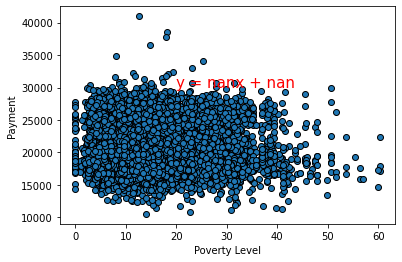

In [166]:
x_values=merged_df.poverty_rate
y_values=merged_df.payment
plot_linear_regression(x_values,y_values,'Payment',(20,30000))
# x_values=gdp_and_life_expectancy_df['Wine Consumption per capita (Liters)']
# y_values=gdp_and_life_expectancy_df['Happiness Score']
# plot_wine_linear_regression(x_values,y_values,'Happiness Score',(3,4))

In [167]:
group1 = merged_df[merged_df["payment_category"] == "No Different Than the National Average Payment"]["poverty_rate"]
group2 = merged_df[merged_df["payment_category"] == "Greater Than the National Average Payment"]["poverty_rate"]
group3 = merged_df[merged_df["payment_category"] == "Less Than the National Average Payment"]["poverty_rate"]

In [168]:
stats.f_oneway(group1, group2, group3)

F_onewayResult(statistic=nan, pvalue=nan)

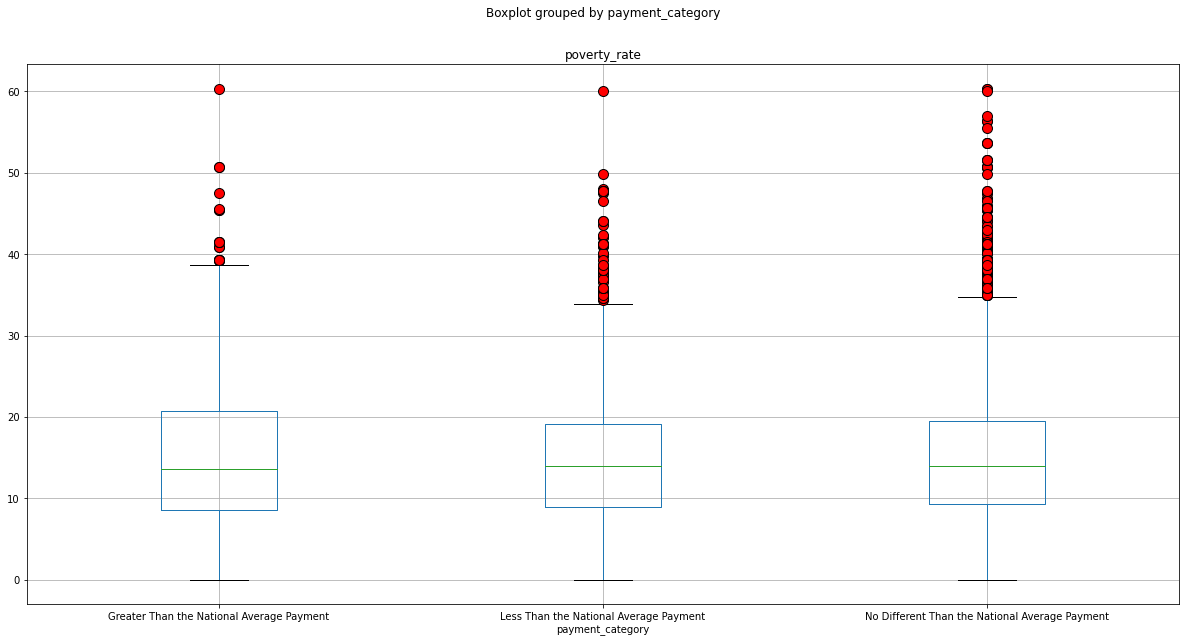

In [169]:
merged_df.boxplot("poverty_rate", by="payment_category", figsize=(20, 10), flierprops=dict(markerfacecolor='red', markersize=10));

In [107]:
# merged_df.to_csv("merged_df.csv", index=False)

### Additional CSV's added

In [171]:
readmissions_df = pd.read_csv("data/Readmissions_Reduction_Program.csv", low_memory=False)
updated_readmissions_df=readmissions_df.drop(['Footnote', 'Start Date', 'End Date', "State", "Facility Name"], axis=1).reset_index(drop=True)
updated_readmissions_df.columns = updated_readmissions_df.columns.str.replace(' ', '_').str.lower()
updated_readmissions_df

,facility_id,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions
0,10001,READM-30-HIP-KNEE-HRRP,258.0,1.1735,5.4150,4.6146,17
1,10001,READM-30-CABG-HRRP,268.0,1.1868,13.8076,11.6339,41
2,10001,READM-30-AMI-HRRP,620.0,1.0204,15.9416,15.6225,100
3,10001,READM-30-HF-HRRP,1107.0,1.0702,23.4423,21.9048,264
4,10001,READM-30-COPD-HRRP,444.0,1.0560,19.6598,18.6179,92
...,...,...,...,...,...,...,...
19219,670143,READM-30-CABG-HRRP,NaN,NaN,NaN,NaN,NaN
19220,670143,READM-30-COPD-HRRP,NaN,NaN,NaN,NaN,NaN
19221,670143,READM-30-HF-HRRP,NaN,NaN,NaN,NaN,NaN
19222,670143,READM-30-HIP-KNEE-HRRP,NaN,NaN,NaN,NaN,NaN


In [176]:
no_nans_readmissions=updated_readmissions_df.dropna()
no_nans_readmissions

,facility_id,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions
0,10001,READM-30-HIP-KNEE-HRRP,258.0,1.1735,5.4150,4.6146,17
1,10001,READM-30-CABG-HRRP,268.0,1.1868,13.8076,11.6339,41
2,10001,READM-30-AMI-HRRP,620.0,1.0204,15.9416,15.6225,100
3,10001,READM-30-HF-HRRP,1107.0,1.0702,23.4423,21.9048,264
4,10001,READM-30-COPD-HRRP,444.0,1.0560,19.6598,18.6179,92
...,...,...,...,...,...,...,...
19143,670120,READM-30-HF-HRRP,170.0,1.1127,23.4930,21.1142,47
19145,670120,READM-30-PN-HRRP,157.0,0.9826,14.7714,15.0323,22
19154,670122,READM-30-COPD-HRRP,88.0,0.9997,19.3508,19.3572,17
19155,670122,READM-30-HF-HRRP,204.0,0.9847,21.5751,21.9106,43


In [178]:
merged_readmissions_df=merged_df.merge(no_nans_readmissions, how='left', on='facility_id')
merged_readmissions_df

,facility_id,facility_name,address,city,state,zip_code,payment_measure_name,payment_category,denominator,payment,...,asian_%,native_hawaiian_%,two_or_more_races_%,hispanic_%,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart attack patients,No Different Than the National Average Payment,574.0,24934.0,...,0.639540,0.047965,2.502198,4.138354,READM-30-HIP-KNEE-HRRP,258.0,1.1735,5.4150,4.6146,17
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart attack patients,No Different Than the National Average Payment,574.0,24934.0,...,0.639540,0.047965,2.502198,4.138354,READM-30-CABG-HRRP,268.0,1.1868,13.8076,11.6339,41
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart attack patients,No Different Than the National Average Payment,574.0,24934.0,...,0.639540,0.047965,2.502198,4.138354,READM-30-AMI-HRRP,620.0,1.0204,15.9416,15.6225,100
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart attack patients,No Different Than the National Average Payment,574.0,24934.0,...,0.639540,0.047965,2.502198,4.138354,READM-30-HF-HRRP,1107.0,1.0702,23.4423,21.9048,264
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Payment for heart attack patients,No Different Than the National Average Payment,574.0,24934.0,...,0.639540,0.047965,2.502198,4.138354,READM-30-COPD-HRRP,444.0,1.0560,19.6598,18.6179,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for pneumonia patients,No Different Than the National Average Payment,205.0,19409.0,...,5.122791,0.031284,2.987643,27.064758,READM-30-HF-HRRP,204.0,0.9847,21.5751,21.9106,43
40996,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for pneumonia patients,No Different Than the National Average Payment,205.0,19409.0,...,5.122791,0.031284,2.987643,27.064758,READM-30-PN-HRRP,234.0,1.0418,17.5646,16.8602,44
40997,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for hip/knee replacement patients,No Different Than the National Average Payment,206.0,21519.0,...,5.122791,0.031284,2.987643,27.064758,READM-30-COPD-HRRP,88.0,0.9997,19.3508,19.3572,17
40998,670122,HOUSTON METHODIST THE WOODLANDS HOSPITAL,17201 INTERSTATE 45 SOUTH,THE WOODLANDS,TX,77385,Payment for hip/knee replacement patients,No Different Than the National Average Payment,206.0,21519.0,...,5.122791,0.031284,2.987643,27.064758,READM-30-HF-HRRP,204.0,0.9847,21.5751,21.9106,43


In [179]:
for column in merged_readmissions_df.columns:
    print(column)

facility_id
facility_name
address
city
state
zip_code
payment_measure_name
payment_category
denominator
payment
value_of_care_display_name
value_of_care_category
population
poverty_rate
caucasian_%
african_american_%
american_indian_%
asian_%
native_hawaiian_%
two_or_more_races_%
hispanic_%
measure_name
number_of_discharges
excess_readmission_ratio
predicted_readmission_rate
expected_readmission_rate
number_of_readmissions


In [ ]:
merged_readmissions_df.to_csv("merged_df.csv", index=False)

In [137]:
outcomes_df = pd.read_csv("data/hvbp_clinical_outcomes.csv", low_memory=False)
outcomes_df

,Fiscal Year,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,MORT-30-AMI Achievement Threshold,MORT-30-AMI Benchmark,...,MORT-30-PN Achievement Points,MORT-30-PN Improvement Points,MORT-30-PN Measure Score,COMP-HIP-KNEE Achievement Threshold,COMP-HIP-KNEE Benchmark,COMP-HIP-KNEE Baseline Rate,COMP-HIP-KNEE Performance Rate,COMP-HIP-KNEE Achievement Points,COMP-HIP-KNEE Improvement Points,COMP-HIP-KNEE Measure Score
0,2021,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,0.860355,0.879714,...,6 out of 10,5 out of 9,6 out of 10,0.031157,0.022418,0.038723,0.022755,9 out of 10,9 out of 9,9 out of 10
1,2021,10005,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,Marshall,0.860355,0.879714,...,0 out of 10,4 out of 9,4 out of 10,0.031157,0.022418,0.028136,0.022954,9 out of 10,9 out of 9,9 out of 10
2,2021,10006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,Lauderdale,0.860355,0.879714,...,0 out of 10,2 out of 9,2 out of 10,0.031157,0.022418,0.030368,0.028330,3 out of 10,2 out of 9,3 out of 10
3,2021,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,Covington,0.860355,0.879714,...,0 out of 10,2 out of 9,2 out of 10,0.031157,0.022418,Not Available,Not Available,Not Available,Not Available,Not Available
4,2021,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,Jefferson,0.860355,0.879714,...,0 out of 10,1 out of 9,1 out of 10,0.031157,0.022418,0.038918,0.023604,8 out of 10,9 out of 9,9 out of 10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,2021,670103,MEDICAL CITY ALLIANCE,3101 NORTH TARRANT PARKWAY,FORT WORTH,TX,76177,Tarrant,0.860355,0.879714,...,1 out of 10,Not Available,1 out of 10,0.031157,0.022418,Not Available,Not Available,Not Available,Not Available,Not Available
2672,2021,670106,HCA HOUSTON HEALTHCARE PEARLAND,11100 SHADOW CREEK PARKWAY,PEARLAND,TX,77584,Brazoria,0.860355,0.879714,...,0 out of 10,Not Available,0 out of 10,0.031157,0.022418,Not Available,Not Available,Not Available,Not Available,Not Available
2673,2021,670108,BAYLOR SCOTT & WHITE MEDICAL CENTER - MARBLE F...,810 W HIGHWAY 71,MARBLE FALLS,TX,78654,Burnet,0.860355,0.879714,...,7 out of 10,Not Available,7 out of 10,0.031157,0.022418,Not Available,0.020216,10 out of 10,Not Available,10 out of 10
2674,2021,670120,THE HOSPITALS OF PROVIDENCE TRANSMOUNTAIN CAMPUS,2000 TRANSMOUNTAIN RD,EL PASO,TX,79911,El Paso,0.860355,0.879714,...,7 out of 10,Not Available,7 out of 10,0.031157,0.022418,Not Available,Not Available,Not Available,Not Available,Not Available


In [138]:
infections_df = pd.read_csv("data/Healthcare_Associated_Infections-Hospital.csv", low_memory=False)
infections_df

,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure ID,Measure Name,Compared to National,Score,Footnote,Start Date,End Date
0,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,HAI_1_CILOWER,Central Line Associated Bloodstream Infection ...,No Different than National Benchmark,0.301,NaN,01/01/2019,12/31/2019
1,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,HAI_1_CIUPPER,Central Line Associated Bloodstream Infection ...,No Different than National Benchmark,1.543,NaN,01/01/2019,12/31/2019
2,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,HAI_1_DOPC,Central Line Associated Bloodstream Infection:...,No Different than National Benchmark,7846,NaN,01/01/2019,12/31/2019
3,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,HAI_1_ELIGCASES,Central Line Associated Bloodstream Infection ...,No Different than National Benchmark,8.086,NaN,01/01/2019,12/31/2019
4,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,HAI_1_NUMERATOR,Central Line Associated Bloodstream Infection ...,No Different than National Benchmark,6,NaN,01/01/2019,12/31/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175747,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,BASTROP,(737) 881-7400,HAI_6_CIUPPER,Clostridium Difficile (C.Diff): Upper Confiden...,Not Available,Not Available,19,01/01/2019,12/31/2019
175748,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,BASTROP,(737) 881-7400,HAI_6_DOPC,Clostridium Difficile (C.Diff): Patient Days,Not Available,Not Available,19,01/01/2019,12/31/2019
175749,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,BASTROP,(737) 881-7400,HAI_6_ELIGCASES,Clostridium Difficile (C.Diff): Predicted Cases,Not Available,Not Available,19,01/01/2019,12/31/2019
175750,670143,ASCENSION SETON BASTROP,"630 HIGWAY 71 W,",BASTROP,TX,78602,BASTROP,(737) 881-7400,HAI_6_NUMERATOR,Clostridium Difficile (C.Diff): Observed Cases,Not Available,Not Available,19,01/01/2019,12/31/2019


### Export to PostgreSQL

In [108]:
from sqlalchemy import create_engine